In [1]:
#from ArcticTools import map
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import glob
%matplotlib inline

In [2]:
nav_lat= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lat'][:]
nav_lon= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lon'][:]
bathy = nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc').variables['Bathymetry'][400:,:]
nclist=['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_19912016.nc',
       # '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav/EXH005-btscav_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_cv/EXH005-btscav2_cv_19912015.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_cs/EXH005-btscav2_cs_19912016.nc'
       ]

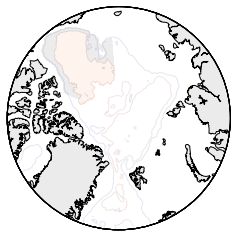

In [3]:
# define areas
shallow=np.load("shallow.npy")
deep3=np.load("deep.npy")
ind = (shallow!=1);shallow[ind]=np.nan
ind = (deep3!=1);deep3[ind]=np.nan

# visualize
m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l',round="True")
n_lon,n_lat = m(nav_lon,nav_lat)
m.contour(n_lon,n_lat,bathy,[1000,3000],alpha=0.1)
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.contourf(n_lon,n_lat, np.ma.masked_invalid(deep3), cmap = 'RdGy',alpha = 0.5)
m.contourf(n_lon,n_lat, np.ma.masked_invalid(shallow), cmap = 'RdGy_r',alpha = 1)

In [4]:
# shallow/deep3[ind]=np.nan is just for plotting purpose; 
# converting them back to 0 for calculation purpose
shallow=np.load("shallow.npy");deep3=np.load("deep.npy")
ind = (shallow!=1);shallow[ind]=0
ind = (deep3!=1);deep3[ind]=0

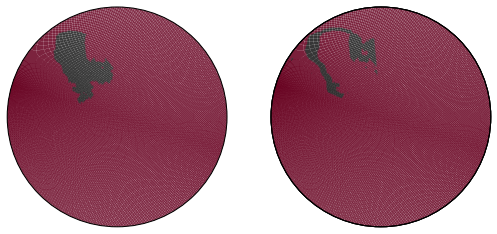

In [5]:
# double check
f,axes = plt.subplots(1,2,figsize = (13/1.5,6/1.5))
m.pcolor(n_lon,n_lat, np.ma.masked_invalid(deep3), cmap = 'RdGy',alpha = 0.2,ax=axes[0])
m.pcolor(n_lon,n_lat, np.ma.masked_invalid(shallow), cmap = 'RdGy',alpha = 0.2,ax=axes[1])

# plot  (u’ - u)2

In [6]:
# plot  (u’ - u)2
def load_velsqu(vel_comp,year,deep_shawlow_file,layer = 30):
    '''
    This function is designed to obtain (square )velocity field
    ======================================================
    '''
    vels ={'usq':'usqure','vsq':'vsqure'}
    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_sqr_vel/EXH005*%s*%s*.nc'%(vel_comp,year))[0]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    data  = np.ma.masked_where(deep_shawlow_file[:] == 0,data)
    return data

def load_vel(vel_comp,year,layer, deep_shawlow_file, ENG = 'EXH005'):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG.upper(),vel_comp,year))[0]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    data  = np.ma.masked_where(deep_shawlow_file[:] == 0,data)
    return data

def ts(dsfile,key='u2',layer=30,data=[]):
    '''dsfile: npy files to define deep or shallow water'''
    for year in range (2002,2015):
            data.append(np.nanmean(load_velsqu(key,np.int(year),dsfile,layer = layer)\
                                  -load_vel('%s'%key[0].upper(),np.int(year),layer,dsfile, ENG = 'exh005')**2))
    return np.array(data)

In [7]:
colors = cm.Spectral(np.linspace(0, 1, 6))

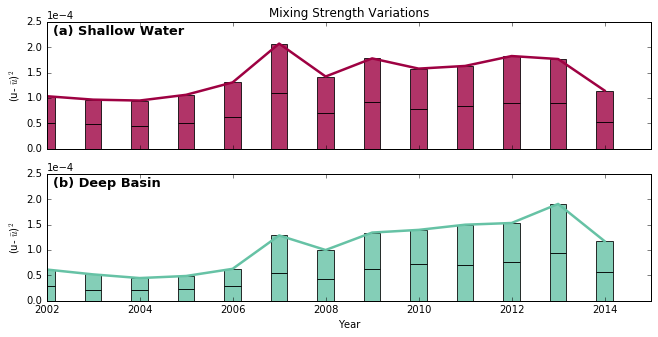

In [8]:
ushallow = ts(shallow,key='usq',data =[])
vshallow = ts(shallow,key='vsq',data =[])

udeep = ts(deep3,key='usq',data =[])
vdeep = ts(deep3,key='vsq',data =[])


f,axes = plt.subplots(2,1,figsize = (13/1.2,6/1.2),sharex=True,sharey=True)
colors = [colors[0],colors[1],colors[-1],colors[-2]]
for ax,u,v,title,c,label in zip (axes,[ushallow,udeep],[vshallow,vdeep],['Shallow Water','Deep Basin'],\
                                 [colors[0],colors[-1]],['(a)','(b)']):
    time = np.linspace(2002,2014,13)
    k = 0;base = 0
    for data in ([u,v]):
        base = u
    ax.plot(time,data+base,lw = 2.5, color=c);k+=1

    p1 = ax.bar(time, u, width=0.35, color=c,label = title,alpha=0.8,align='center')#,label = 'u direction')
    p2 = ax.bar(time, v, width=0.35, color=c,bottom=u,alpha=0.8,align='center')#,label = 'v direction')
    ax.set_xlim(2002,2015);ax.set_ylim(0,0.00025)
    #ax.legend(frameon=False)

    ax.set_ylabel(r'(u- $\bar{u}$)$^{2}$')
    ax.text(0.01,0.9, '%s %s'%(label,title), weight='bold',\
                transform=ax.transAxes, ha='left', fontsize=13)
    ax.set_ylim(0,0.00025)
axes[0].set_title('Mixing Strength Variations')    
axes[-1].set_xlabel(r'Year')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.tight_layout()
    

# plot tracer

In [9]:
# plot tracer
def time_variation_thdata(label,deep_shawlow_file,layer = 30):
    local_nclist = 1; layer =30 #local variable
    if label == "Base Run": local_nclist = 1  
    if label == "Experimental run -vel": local_nclist = 2 
    if label == "Experimental run -ice": local_nclist = 3 
    data = nc.Dataset(nclist[local_nclist]).variables['TR_8'][:,layer,...] 
    for i in range(data.shape[0]):
        data[i,...] = data[i,...]*deep_shawlow_file[:]
    data[data==0]=np.nan
    datam= np.nanmean(data,axis=(1,2))-np.nanmean(data,axis=(1,2))[11]
    return datam

def time_base_thdata(label,deep_shawlow_file,layer = 30):
    local_nclist = 1; layer =30 #local variable
    if label == "Base Run": local_nclist = 1  
    if label == "Experimental run -vel" : local_nclist = 2 
    if label == "Experimental run -Ice": local_nclist = 3 
    data = nc.Dataset(nclist[local_nclist]).variables['TR_8'][:,layer,...]
    for i in range(data.shape[0]):
        data[i,...] = data[i,...]*deep_shawlow_file[:]
    data[data==0]=np.nan
    datai= np.nanmean(data,axis=(1,2))[11]
    return datai

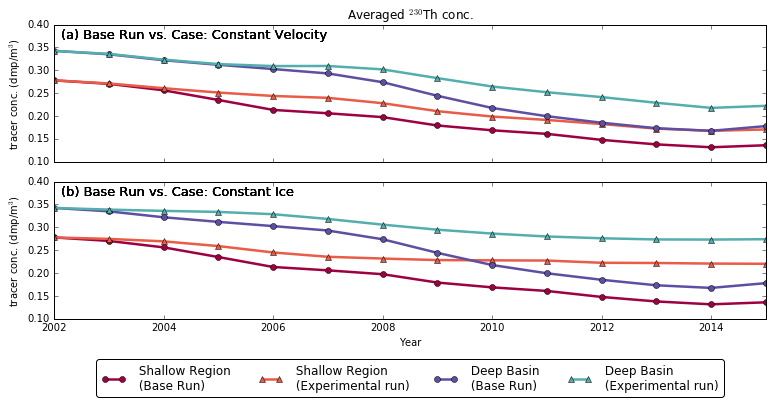

In [10]:
colors = cm.Spectral(np.linspace(0, 1, 7))
f,axes = plt.subplots(2,1,figsize = (13/1.2,6/1.2),sharex=True,sharey=True)
colors = [colors[0],colors[1],colors[-1],colors[-2]]

k=0
for ax,dsfile,title in zip ([axes[0],axes[0]],[shallow,deep3],['Shallow Region','Deep Basin']):
    for i,label,marker in zip (range (len(nclist)),['Base Run','Experimental run -vel'],['-o','-^']):
        barchart_data = time_variation_thdata(label,dsfile)
        trendline_data= time_base_thdata(label,dsfile) \
                    + time_variation_thdata(label,dsfile)
            
        time = np.linspace(1991,1990+barchart_data.shape[0],barchart_data.shape[0])
        #if label != 'Base Run': ax.bar(time,-barchart_data,width=0.5,color=colors[k]) 
        ax.plot(time,trendline_data,marker,lw = 2.5, label =' %s \n (%s)'%(title,label), color=colors[k])
        
        ax.set_xlim(2002,2015)#  
        ax.set_ylabel('tracer conc. (dmp/m$^3$)')
        ax.set_title("Averaged $^{230}$Th conc.")
        ax.text(0.01,0.9, '(a) Base Run vs. Case: Constant Velocity', \
                transform=ax.transAxes, ha='left', fontsize=13)
        k+=1

k = 0         
for ax,dsfile,title in zip ([axes[1],axes[1]],[shallow,deep3],['Shallow Region','Deep Basin']):
    for i,label,marker in zip (range (len(nclist)),['Base Run','skip','Experimental run -ice'],['-o',_,'-^']):
        if label != 'skip':
            barchart_data = time_variation_thdata(label,dsfile)
            trendline_data= time_base_thdata(label,dsfile) \
                    + time_variation_thdata(label,dsfile)
            
            time = np.linspace(1991,1990+barchart_data.shape[0],barchart_data.shape[0])
            #if label != 'Base Run': ax.bar(time,-barchart_data,width=0.5,color=colors[k]) 
            ax.plot(time,trendline_data,marker,lw = 2.5, label =' %s \n (%s)'%(title,label[:16]), color=colors[k])

            ax.set_xlim(2002,2015)# for axy in ax]
            #if title == 'Shallow Region':
            #    axes[1].legend(loc=3,frameon=False)
            ax.set_ylabel('tracer conc. (dmp/m$^3$)')
            ax.set_xlabel('Year')
            ax.text(0.01,0.9, '(b) Base Run vs. Case: Constant Ice', \
                transform=ax.transAxes, ha='left', fontsize=13)
            k+=1
 
axes[1].legend(loc='upper center', bbox_to_anchor=(.5, -.25),
          ncol=4, fancybox=True)
plt.tight_layout()